In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils import *
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

In [3]:
error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSN/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSN/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSN/x.csv')
error_distracted_list, u_signal_distracted_list, x_signal_distracted_list         = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDCE/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDCE/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDCE/x.csv')

In [4]:
error_signal_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/e.csv', delimiter=',')
tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/mdist.csv', delimiter=',')
u_signal_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/u.csv', delimiter=',')
x_signal_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PSDPE/x.csv', delimiter=',')

In [5]:
person_idx = 0
idx = person_idx*4 + 0

# combine the entire list in the priors
error_not_distracted = np.concatenate(error_not_distracted_list[person_idx])
u_not_distracted = np.concatenate(u_signal_not_distracted_list[person_idx])
x_not_distracted = np.concatenate(x_signal_not_distracted_list[person_idx])

error_distracted = np.concatenate(error_distracted_list[person_idx])
u_distracted = np.concatenate(u_signal_distracted_list[person_idx])
x_distracted = np.concatenate(x_signal_distracted_list[person_idx])

X_not_distracted = np.stack(
    [error_not_distracted, u_not_distracted], axis=-1
)

X_distracted = np.stack([error_distracted, u_distracted], axis=-1)

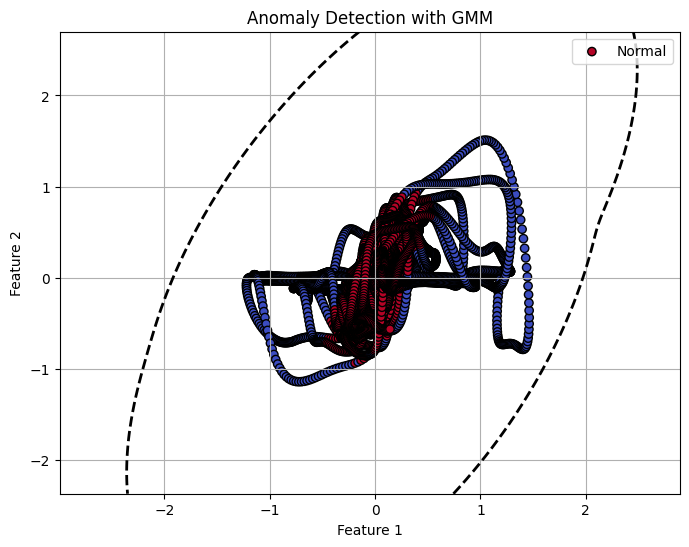

Number of anomalies detected: 15742
[[-0.09204075 -0.41765161]
 [ 0.13493751  0.39641604]]
[[[0.03754396 0.02846955]
  [0.02846955 0.07810585]]

 [[0.04040278 0.0323117 ]
  [0.0323117  0.07325697]]]


In [6]:

# Fit GMM to the normal data (X_not_distracted)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_not_distracted)

# Compute log-likelihood for all data
log_likelihood = gmm.score_samples(X_distracted)

# Determine anomaly threshold (e.g., 4th percentile of normal data)
threshold = np.percentile(gmm.score_samples(X_not_distracted), 10)

# Classify anomalies
anomalies = log_likelihood < threshold

# Plot results
plt.figure(figsize=(8, 6))

# Plot the first 5000 points of X_distracted, color-coded by anomaly status
plt.scatter(X_distracted[:5000, 0], X_distracted[:5000, 1], c=~anomalies[:5000], cmap='coolwarm', edgecolors='k')

# Plot decision boundary contours
x_min, x_max = X_distracted[:, 0].min() - 1, X_distracted[:, 0].max() + 1
y_min, y_max = X_distracted[:, 1].min() - 1, X_distracted[:, 1].max() + 1

# Create a meshgrid for the feature space
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Evaluate GMM on the grid points
Z = gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour of the decision boundary (threshold)
contour_levels = [np.percentile(Z, 40)]  # Specify a single level (e.g., 4th percentile threshold)
plt.contour(xx, yy, Z, levels=contour_levels, linewidths=2, colors='black', linestyles='dashed')

# Additional plot settings
plt.title('Anomaly Detection with GMM')
plt.legend(['Normal', 'Anomaly'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.show()

# Output the number of anomalies detected
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# print the mean and covariance of the GMM
print(gmm.means_)
print(gmm.covariances_)


In [7]:
# Fit KDE to the normal data (X_not_distracted)
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)  # You can tune the bandwidth
kde.fit(X_not_distracted[:10000])

# Evaluate the log-likelihood for all data (X_distracted)
log_likelihood = kde.score_samples(X_distracted)

# Determine anomaly threshold (e.g., 4th percentile of normal data)
threshold = np.percentile(kde.score_samples(X_not_distracted), 4)

# Classify anomalies
anomalies = log_likelihood < threshold

# Evaluate KDE on the grid points
Z = kde.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Output the number of anomalies detected
print(f"Number of anomalies detected: {np.sum(anomalies)}")


Number of anomalies detected: 6788


In [8]:
# Assuming X_not_distracted and X_distracted are your datasets
# Fit KDE to the normal data (X_not_distracted)
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)  # You can tune the bandwidth
kde.fit(X_not_distracted)

# Create a meshgrid for the feature space to evaluate the KDE on
x_min, x_max = X_distracted[:, 0].min() - 1, X_distracted[:, 0].max() + 1
y_min, y_max = X_distracted[:, 1].min() - 1, X_distracted[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Evaluate KDE on the grid points
Z = kde.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot results
plt.figure(figsize=(8, 6))

# Plot the first 5000 points of X_distracted, color-coded by anomaly status
log_likelihood_distracted = kde.score_samples(X_distracted)
threshold = np.percentile(kde.score_samples(X_not_distracted), 4)
anomalies = log_likelihood_distracted < threshold

# # You can adjust the percentage thresholds for anomalies if needed
# plt.scatter(X_distracted[:5000, 0], X_distracted[:5000, 1], c=~anomalies[:5000], cmap='coolwarm', edgecolors='k')

# # Plot decision boundary contours for different percentiles of the log-likelihood
# percentiles = [1, 4, 10, 50]  # List of thresholds (percentiles)
# for p in percentiles:
#     print(f"Percentile {p}")
#     contour_level = np.percentile(Z, p)  # Calculate contour level for each percentile
#     plt.contour(xx, yy, Z, levels=[contour_level], linewidths=2, linestyles='dashed', label=f'{p}th percentile')

# Additional plot settings
plt.title('Anomaly Detection with KDE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.grid()
plt.show()

# Output the number of anomalies detected
print(f"Number of anomalies detected: {np.sum(anomalies)}")


KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

(480000,)
16529 distracted points
16529 distracted error points
16529 distracted u points
(48000, 2)


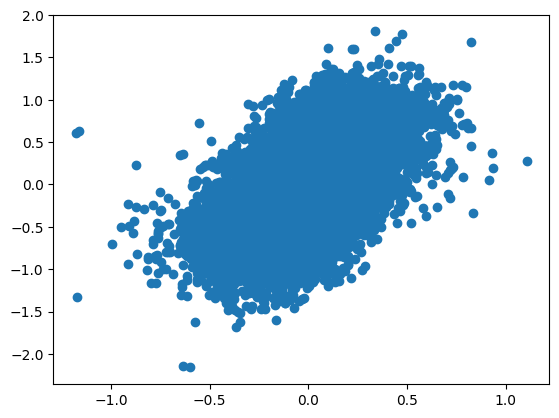

In [9]:
# X_distracted = np.stack([np.concatenate(error_not_distracted_list), np.concatenate(u_signal_not_distracted_list)], axis=-1)

# plot only the points where tc_test == 1
distracted_times = np.where(np.concatenate(tc_test) == 1)[0]
print(f"{np.concatenate(np.concatenate(error_not_distracted_list)).shape}")
distracted_error = np.concatenate(np.concatenate(error_not_distracted_list))[distracted_times]
distracted_u = np.concatenate(np.concatenate(u_signal_not_distracted_list))[distracted_times]

print(f"{distracted_times.shape[0]} distracted points")
print(f"{distracted_error.shape[0]} distracted error points")
print(f"{distracted_u.shape[0]} distracted u points")

print(X_distracted.shape)

plt.scatter(distracted_error, distracted_u)
plt.show()

In [10]:
# Example dataset: 2D points
def compute_density(error_signal_list, u_signal_list, x_signal_list, person_idx, bandwidth=0.2):

    error_signal = np.concatenate(error_signal_list[person_idx])
    u_signal = np.concatenate(u_signal_list[person_idx])
    x_signal = np.concatenate(x_signal_list[person_idx])

    X_data_matrix = np.stack([error_signal, u_signal], axis=-1)

    # Fit a KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)  # Adjust bandwidth for smoothing
    kde.fit(X_data_matrix)

    # Define a grid over the data range
    x_min, x_max = X_data_matrix[:, 0].min() - 1, X_data_matrix[:, 0].max() + 1
    y_min, y_max = X_data_matrix[:, 1].min() - 1, X_data_matrix[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    extent = (x_min, x_max, y_min, y_max)

    # Evaluate the KDE on the grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    log_density = kde.score_samples(grid_points)
    density = np.exp(log_density).reshape(xx.shape)
    
    return density, extent

# Example usage:
person_idx = 1
density, extent = compute_density(error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list, person_idx)


In [ ]:
import numpy as np
from sklearn.neighbors import KernelDensity
import pickle  # For saving and loading the KDE object

# Function to compute density and return the KDE object
def compute_density(error_signal_list, u_signal_list, x_signal_list, person_idx, bandwidth=0.2):
    error_signal = np.concatenate(error_signal_list[person_idx])
    u_signal = np.concatenate(u_signal_list[person_idx])
    x_signal = np.concatenate(x_signal_list[person_idx])

    X_data_matrix = np.stack([error_signal, u_signal], axis=-1)

    # Fit a KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)  # Adjust bandwidth for smoothing
    kde.fit(X_data_matrix)

    

    # Define a grid over the data range for visualization (optional)
    x_min, x_max = X_data_matrix[:, 0].min() - 1, X_data_matrix[:, 0].max() + 1
    y_min, y_max = X_data_matrix[:, 1].min() - 1, X_data_matrix[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    extent = (x_min, x_max, y_min, y_max)

    # Evaluate the KDE on the grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    log_density = kde.score_samples(grid_points)
    density = np.exp(log_density).reshape(xx.shape)
    
    return kde, density, extent

# Function to compute probabilities for new data using the saved KDE
def compute_kde_probabilities(X_test, kde_model_path):
    # Load the KDE model
    with open(kde_model_path, 'rb') as f:
        kde = pickle.load(f)

    # Compute log densities for the new data
    log_probabilities = kde.score_samples(X_test)
    probabilities = np.exp(log_probabilities)  # Convert log probabilities to probabilities
    
    return probabilities

# Example usage:
person_idx = 1
kde, density, extent = compute_density(error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list, person_idx)

# Test data
X_test = np.array([[0.1, 0.2], [0.5, 0.6], [0.7, 0.8]])  # Replace with actual test data

# Compute probabilities for X_test
probabilities = compute_kde_probabilities(X_test, f'kde_person_{person_idx}.pkl')
print(probabilities)


/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


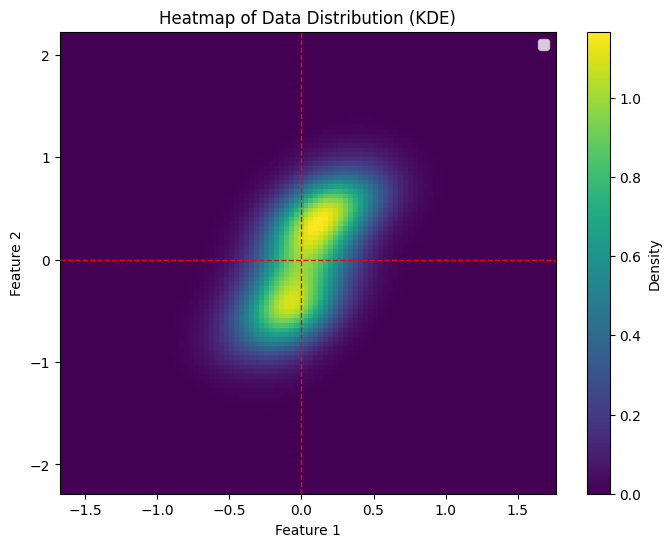

/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


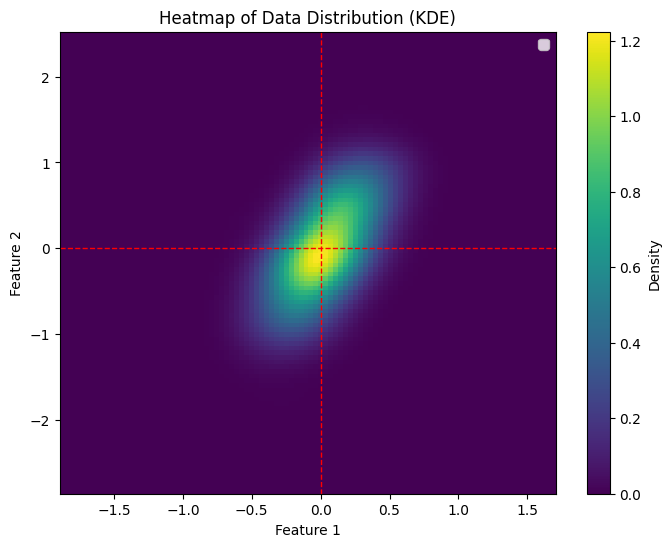

/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


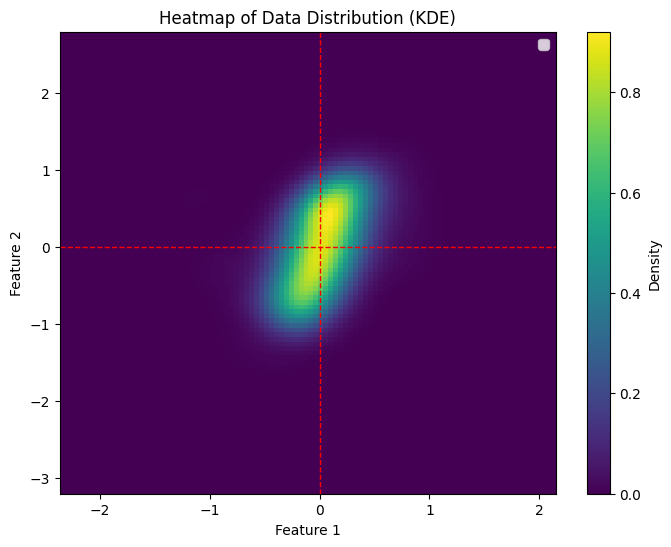

/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


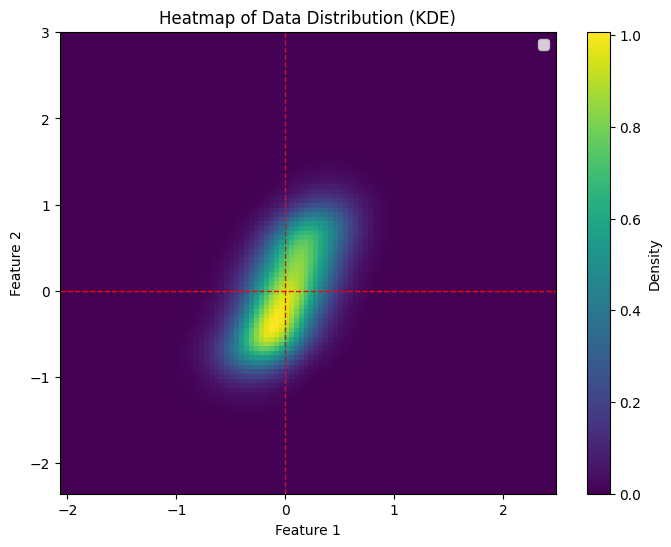

/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


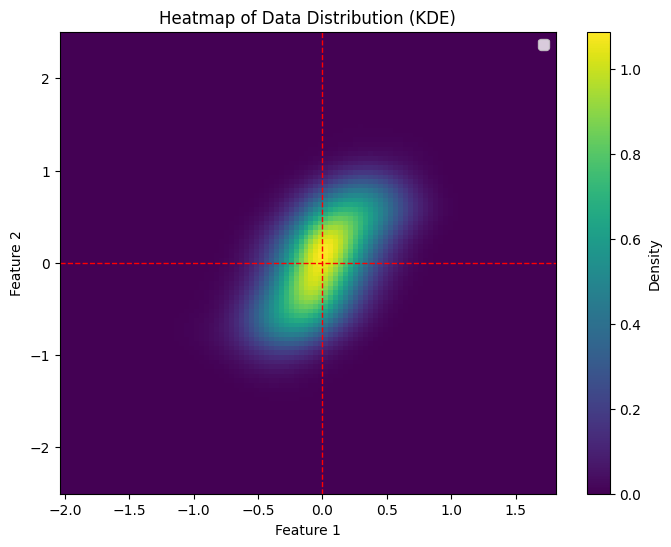

/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


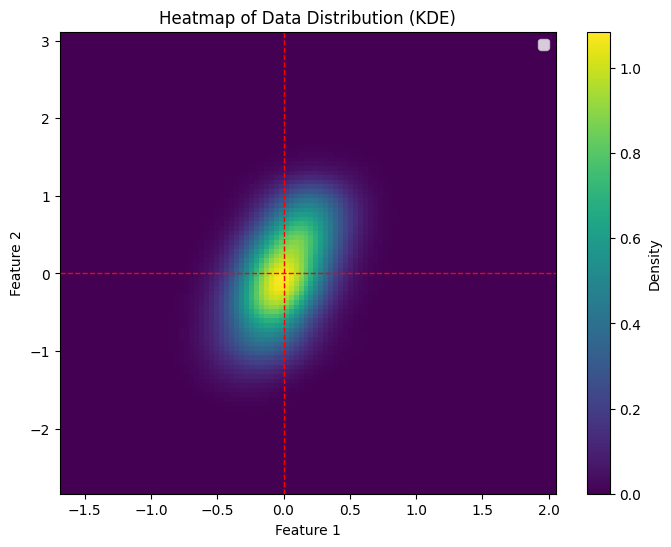

/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


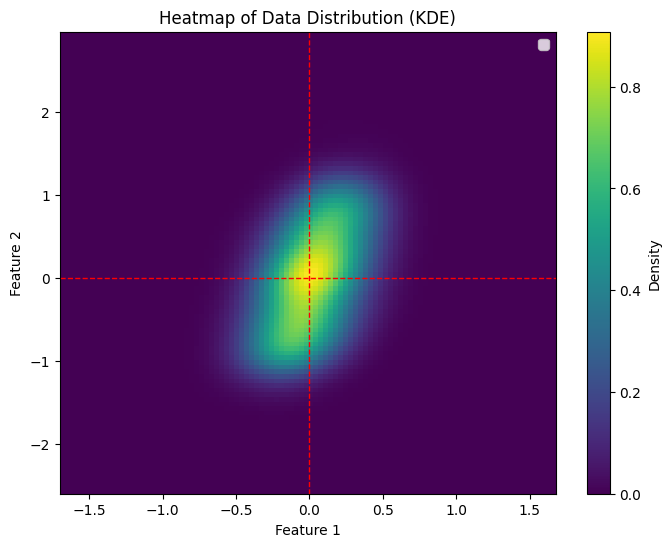

/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


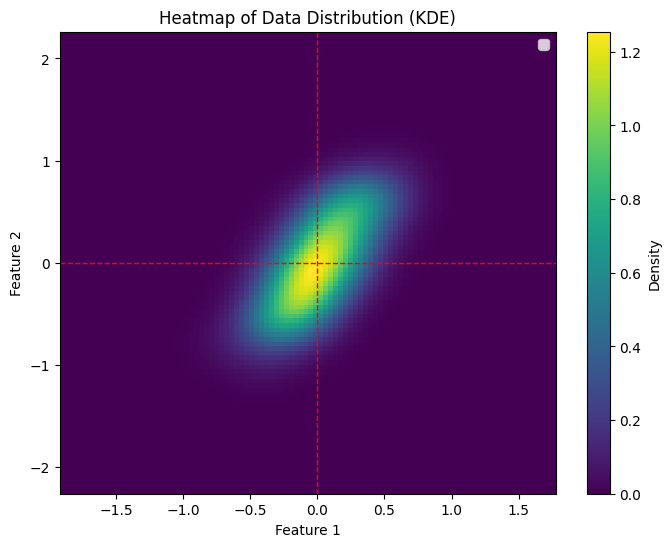

/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


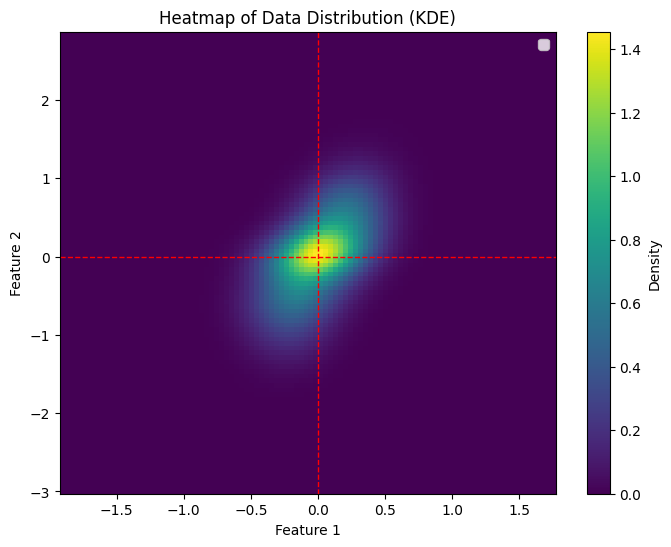

/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


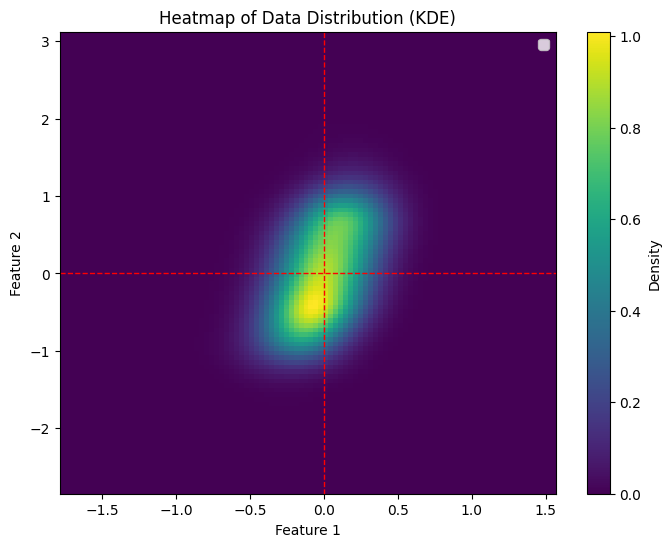

In [ ]:
def plot_heatmap(density, extent):
    (x_min, x_max, y_min, y_max) = extent 
    plt.figure(figsize=(8, 6))
    # add a vertical line at x=0 and a horizontal line at y=0
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.imshow(density, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(label='Density')
    #plt.scatter(X_distracted[:, 0], X_distracted[:, 1], s=5, c='white', label='Data Points', alpha=0.6)
    plt.title('Heatmap of Data Distribution (KDE)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(False)
    plt.show()

# Example usage:
for person_idx in range(10):
    density, extent = compute_density(error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list, person_idx, bandwidth=0.15)
    
    # Save the KDE model to a file
    with open(f'kde_person_{person_idx}.pkl', 'wb') as f:
        pickle.dump(kde, f)

    plot_heatmap(density, extent)


/tmp/ipykernel_389313/2101505160.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


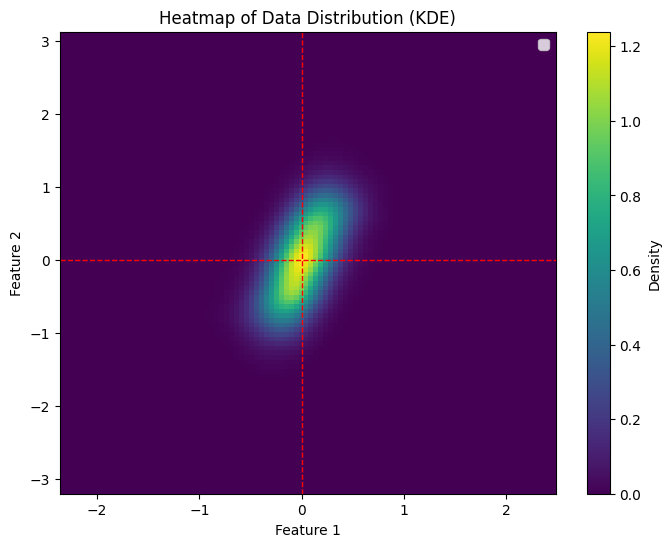

In [12]:
def compute_density_for_all(error_signal_list, u_signal_list, x_signal_list):

    error_signal = np.concatenate([np.concatenate(error_signal_list[person_idx]) for person_idx in range(10)])
    u_signal = np.concatenate([np.concatenate(u_signal_list[person_idx]) for person_idx in range(10)])
    # x_signal = np.concatenate(x_signal_list[person_idx])

    X_data_matrix = np.stack([error_signal, u_signal], axis=-1)

    # Fit a KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)  # Adjust bandwidth for smoothing
    kde.fit(X_data_matrix)

    # Define a grid over the data range
    x_min, x_max = X_data_matrix[:, 0].min() - 1, X_data_matrix[:, 0].max() + 1
    y_min, y_max = X_data_matrix[:, 1].min() - 1, X_data_matrix[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    extent = (x_min, x_max, y_min, y_max)

    # Evaluate the KDE on the grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    log_density = kde.score_samples(grid_points)
    density = np.exp(log_density).reshape(xx.shape)
    
    return density, extent

# Example usage:
person_idx = 1
density, extent = compute_density_for_all(error_not_distracted_list, u_signal_not_distracted_list, x_signal_not_distracted_list)
plot_heatmap(density, extent)